# Tutorial 02: Customise prior for various domain type
We will see how to customise the SOBER algorithm for various domain type.<br>

We will consider the following domain types (click link to skip):
- continuous variables with known bounds <a href="#section1">link</a>
- continuous variables with unknown bounds <a href="#section2">link</a>
- continuous variables with expert knowledge <a href="#section3">link</a>
- binary variables <a href="#section4">link</a>
- categorical variables <a href="#section5">link</a>
- mixture of continuous and binary variables <a href="#section6">link</a>
- mixture of continuous and categorical variables <a href="#section7">link</a>
- domain as a dataset (drug discovery) <a href="#section8">link</a>

## 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt

# need pandas and seaborn for visualisation
import pandas as pd
import seaborn as sns
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<a id ="section1"></a>
## 1. Continuous variables with known bounds
Let's get started with the toy example of 6-dimensional Hartmann function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/hart6.html)<br>
- number of dimensions: 6
- bounds: 0 from 1
- variable type: continuous
- ground truth: 3.32237
- optimisation: maximisation

In [2]:
from botorch.test_functions import Hartmann
hart6 = Hartmann(dim=6, negate=True)

def TestFunction(x):
    return hart6(x)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 1.1 Define the prior (domain)
We will define the prior distribution of global optimum location. <br>
We assume we don't know the global optimum location, so we use a non-informative prior, namely, the uniform prior. <br>
All we need to specify is the upper and lower bounds of the function. <br>
We know this is bounded from 0 to 1, so we set uniform prior as so.<br>

In [3]:
# set bounds
n_dims = 6                          # number of dimensions
lower_limit = 0
upper_limit = 1
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds, n_dims)

### 1.2 Visualise the prior
Check the prior for sanity check.

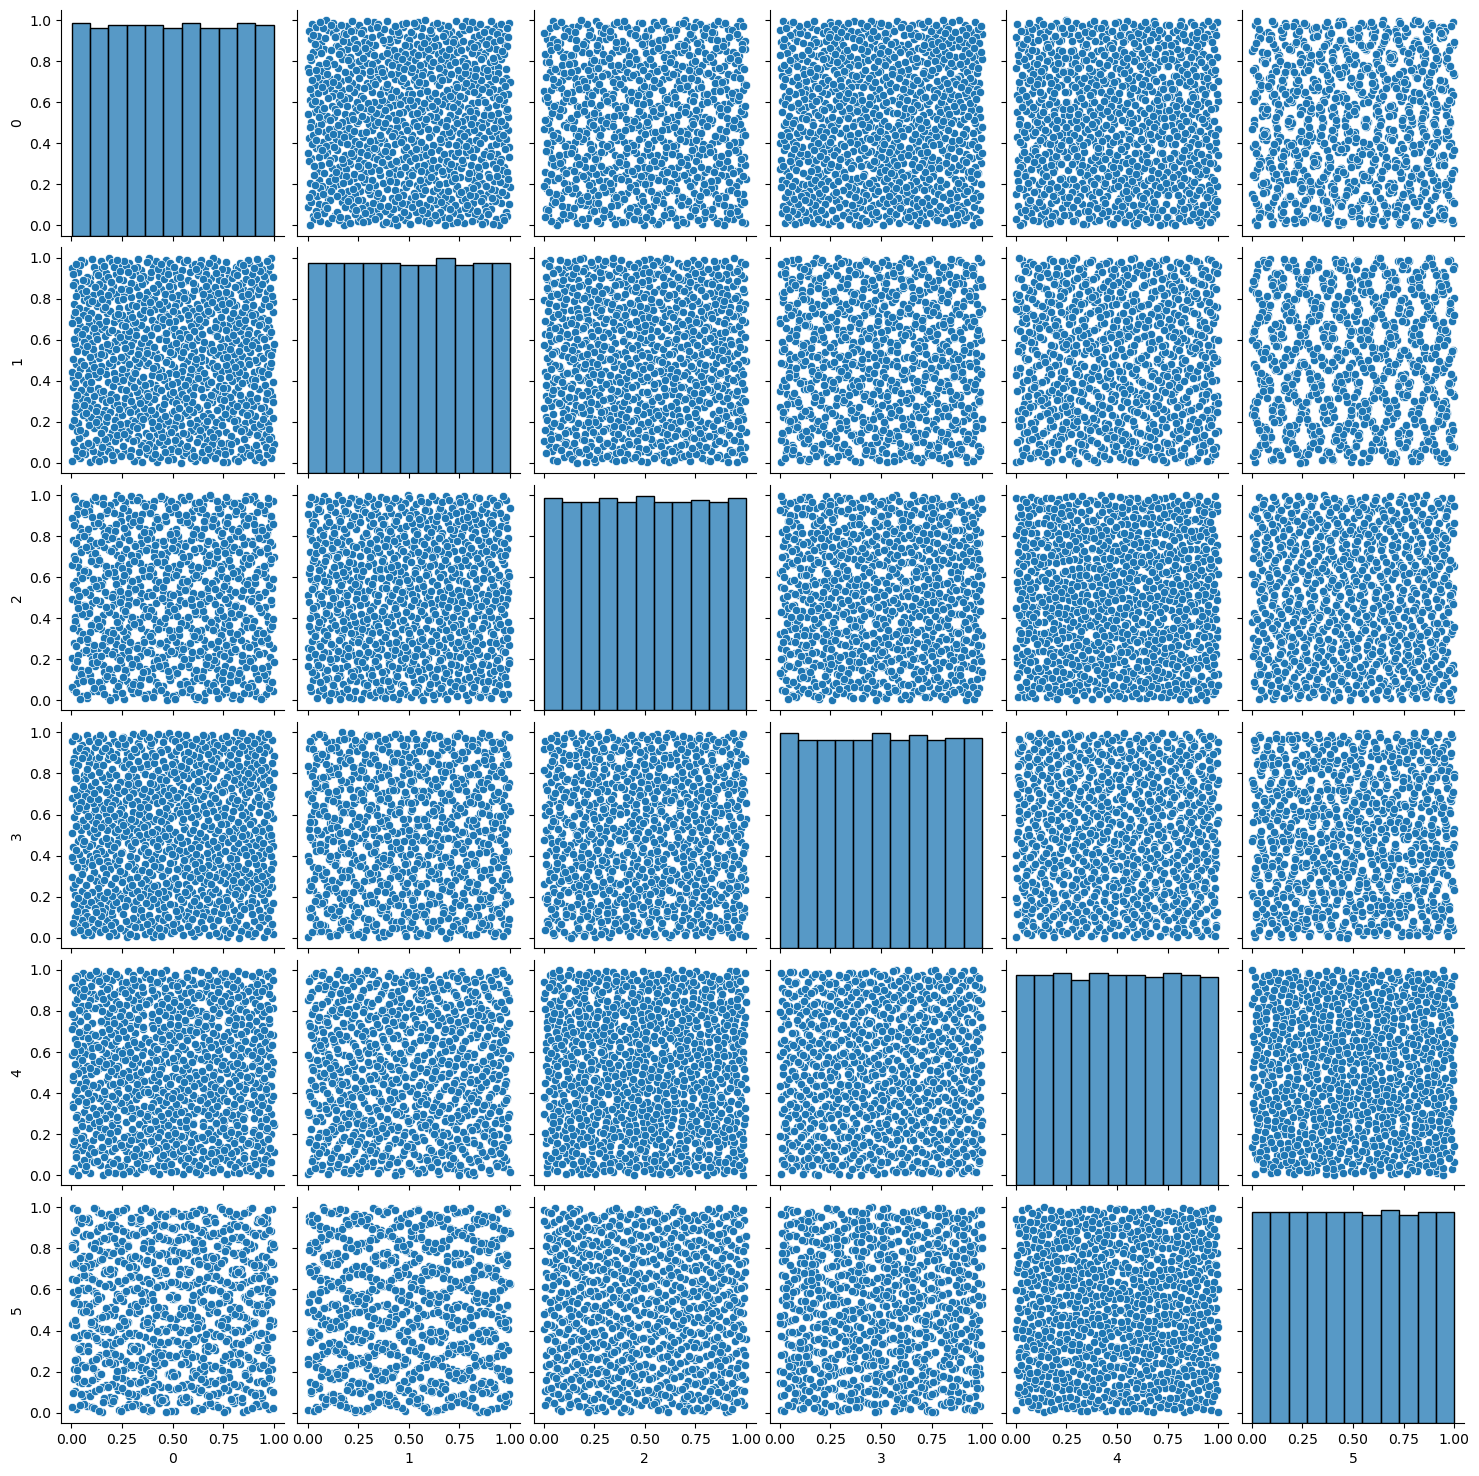

In [4]:
samples = prior.sample(1000)
sns.pairplot(pd.DataFrame(samples.numpy()))

We can check that the samples from prior follow the uniform distribution bounded between 0 and 1.

### 1.3 Run SOBER
That's all! Now we can run SOBER.

In [5]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [6]:
from SOBER._sober import Sober

def run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=None,          # acquisition function
):
    torch.manual_seed(seed)  # random seed

    # initial sampling
    Xall = prior.sample(n_init)
    Yall = TestFunction(Xall)
    model = set_rbf_model(Xall, Yall)
    sober = Sober(prior, model)

    results = []
    for n_iter in range(n_iterations):
        start = time.monotonic()
        model = set_rbf_model(Xall, Yall)   # GP model with RBF kernel
        model = optimise_model(model)       # Optimise hyperparameters
        sober.update_model(model)           # pass the updated model to sober
        X_batch = sober.next_batch(
            n_rec,
            n_nys,
            batch_size,
            calc_obj=obj,
            verbose=False,
        )
        end = time.monotonic()
        interval = end - start

        Y_batch = TestFunction(X_batch)
        Xall = torch.cat((Xall, X_batch), dim=0)
        Yall = torch.cat((Yall, Y_batch), dim=0)

        print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
        print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
        results.append([interval, Yall.max().item()])
    return torch.tensor(results)

def visualise_results(results, y_true=None):
    idx_batch = torch.arange(n_iterations)

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    ax[0].plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
    if not y_true == None:
        ax[0].axhline(y=y_true, linestyle="--", color="k", label="ground truth")
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")

    ax[1].plot(idx_batch, results[:,0], 'bo-')
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    plt.show()

110) Best value: 2.46961e+00
Acquisition time [s]: 7.81101e+00, per sample [ms]: 7.81101e+02
120) Best value: 2.46961e+00
Acquisition time [s]: 1.01201e+01, per sample [ms]: 1.01201e+03
130) Best value: 2.75910e+00
Acquisition time [s]: 1.01737e+01, per sample [ms]: 1.01737e+03
140) Best value: 3.05093e+00
Acquisition time [s]: 9.84722e+00, per sample [ms]: 9.84722e+02
150) Best value: 3.19941e+00
Acquisition time [s]: 1.05595e+01, per sample [ms]: 1.05595e+03


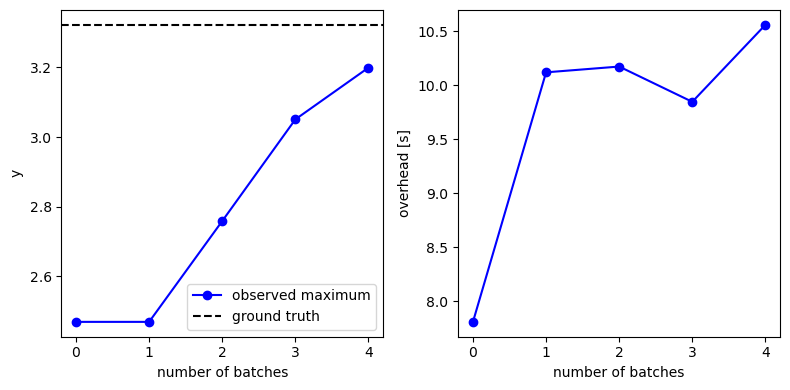

In [7]:
seed = 10          # random seed
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=3.32237)

<a id ="section2"></a>
## 2. Continuous variables with unknown bounds
Next, we assume we don't know the bounds.
We assume the prior as Gaussian distribution.

In [8]:
# set bounds
n_dims = 6                          # number of dimensions
mean = 0.5 * torch.ones(n_dims)
covariance = (0.5 ** 2) * torch.eye(n_dims)

# set prior
from SOBER._prior import Gaussian   # Import prior from SOBER libraries
prior = Gaussian(mean, covariance)

### 2.1 Visualise prior

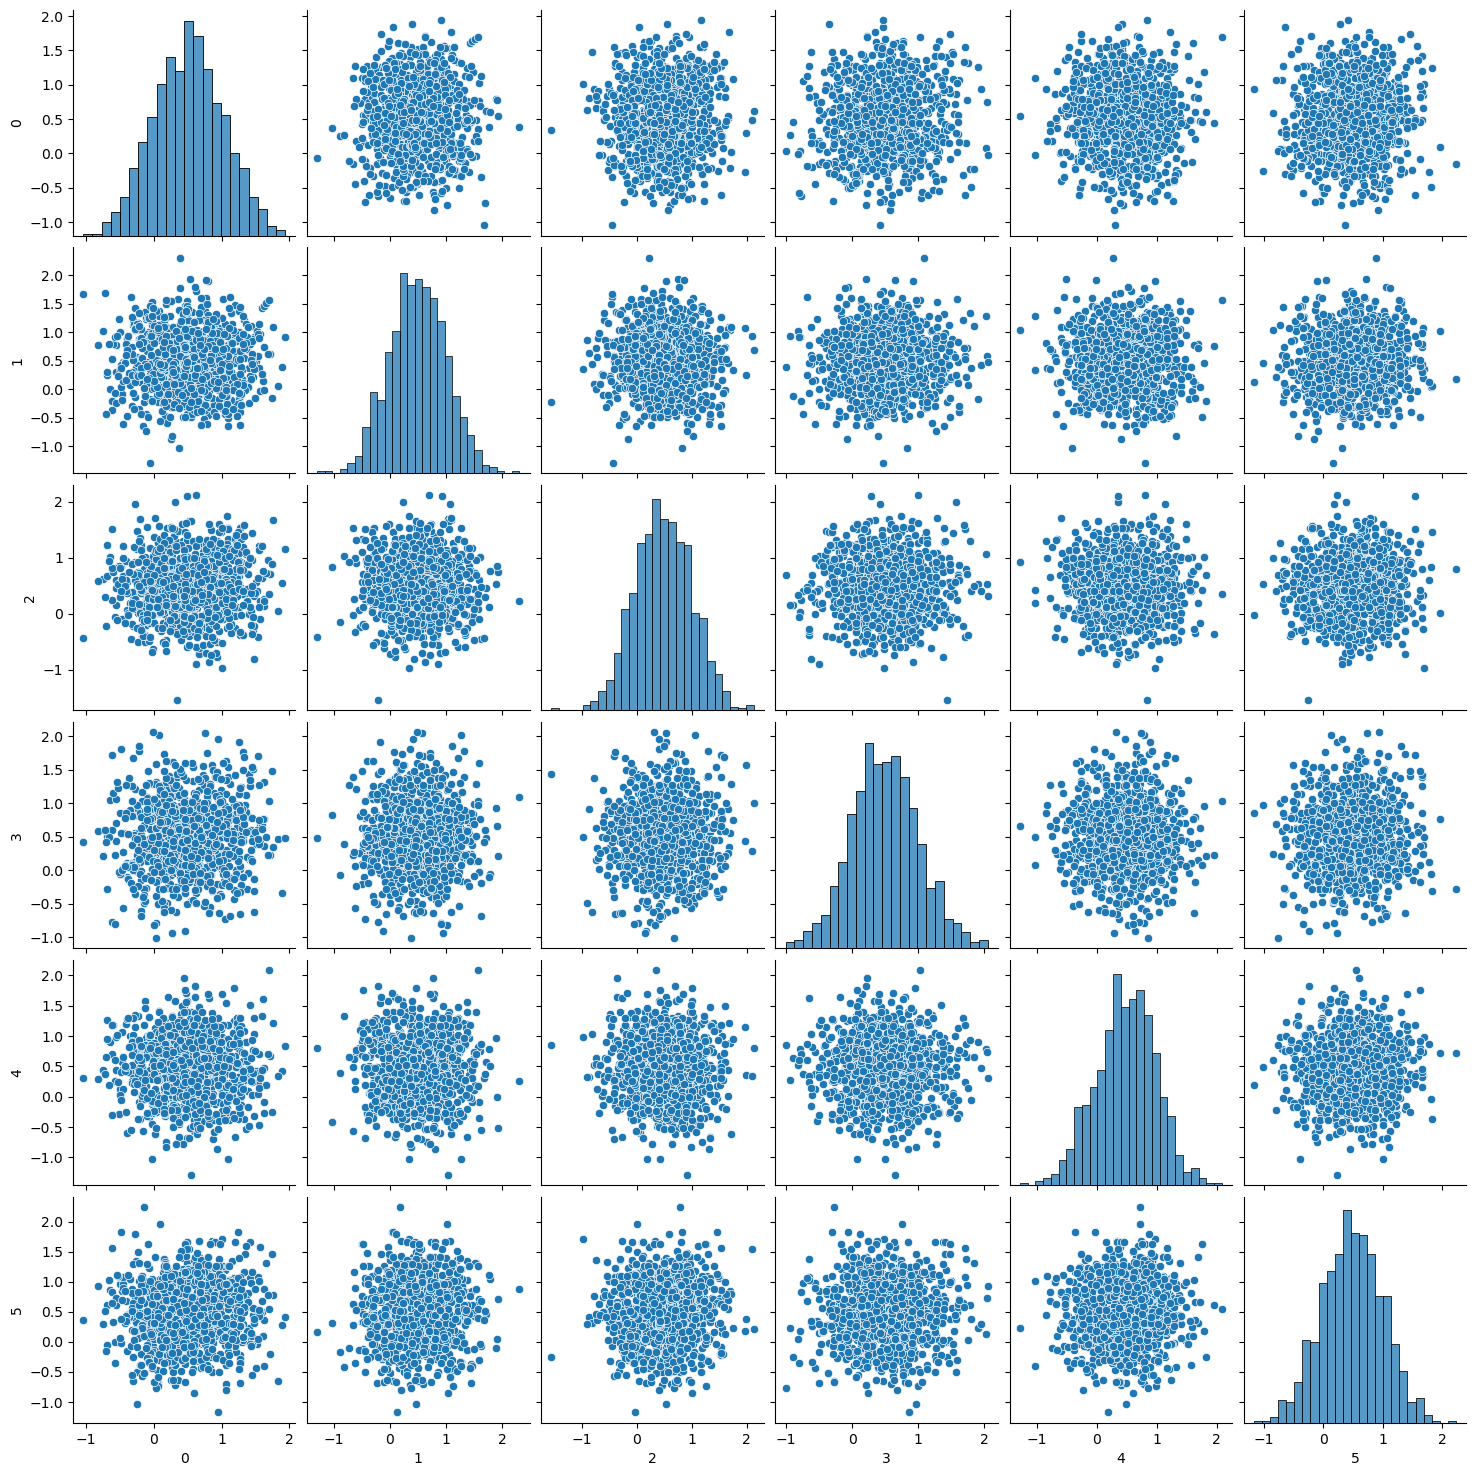

In [9]:
samples = prior.sample(1000)
sns.pairplot(pd.DataFrame(samples.numpy()))
plt.show()

We can check that the samples follow a Gaussian distribution with the mean at 0.5 and the standard deviation of 0.5.

### 2.3 Run SOBER
That's all! Now we can run SOBER.

110) Best value: 1.69077e+00
Acquisition time [s]: 2.43182e+00, per sample [ms]: 2.43182e+02
120) Best value: 2.06384e+00
Acquisition time [s]: 7.52386e+00, per sample [ms]: 7.52386e+02
130) Best value: 2.72386e+00
Acquisition time [s]: 7.27497e+00, per sample [ms]: 7.27497e+02
140) Best value: 3.23224e+00
Acquisition time [s]: 6.85390e+00, per sample [ms]: 6.85390e+02
150) Best value: 3.23224e+00
Acquisition time [s]: 8.83946e+00, per sample [ms]: 8.83946e+02


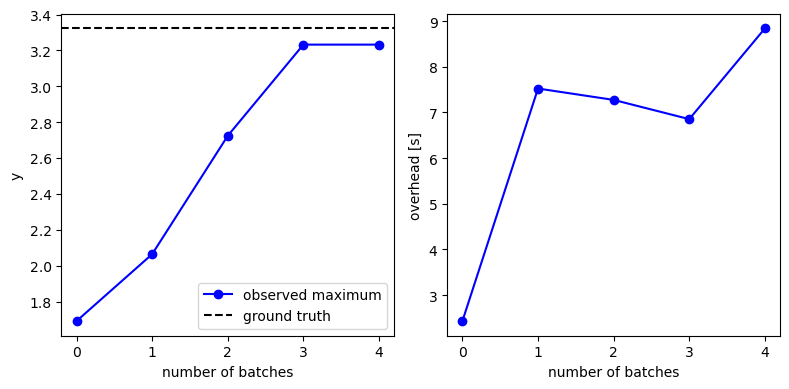

In [10]:
seed = 0           # random seed
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=3.32237)

The start isn't going as well as known bounds. <br>
But, SOBER can find better locations over iterations. <br>

<a id ="section3"></a>
## 3. Continuous variables with expert knowledge
We consider the case where the human experts vaguely know the global optimum locations.<br>
We assume the experts knowledge can be described as a Gaussian distribution, with the mean is the "educated guess" of the expert, and covariance is the uncertainties of this estimation.<br>
We assume the Gaussian noise over this estimation uncertainty.<br>

In [11]:
from torch.distributions import MultivariateNormal

# ground truth
x_true = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])

# Setting expert's guess
guess_covariance = torch.tensor([0.001,0.002,0.001,0.0025,0.0022,0.0015]).diag()
noise = MultivariateNormal(torch.zeros(n_dims), guess_covariance).sample()
guess_mean = x_true + noise

# Set prior
from SOBER._prior import Gaussian   # Import prior from SOBER libraries
prior = Gaussian(guess_mean, guess_covariance)

### 3.1 Visualise prior

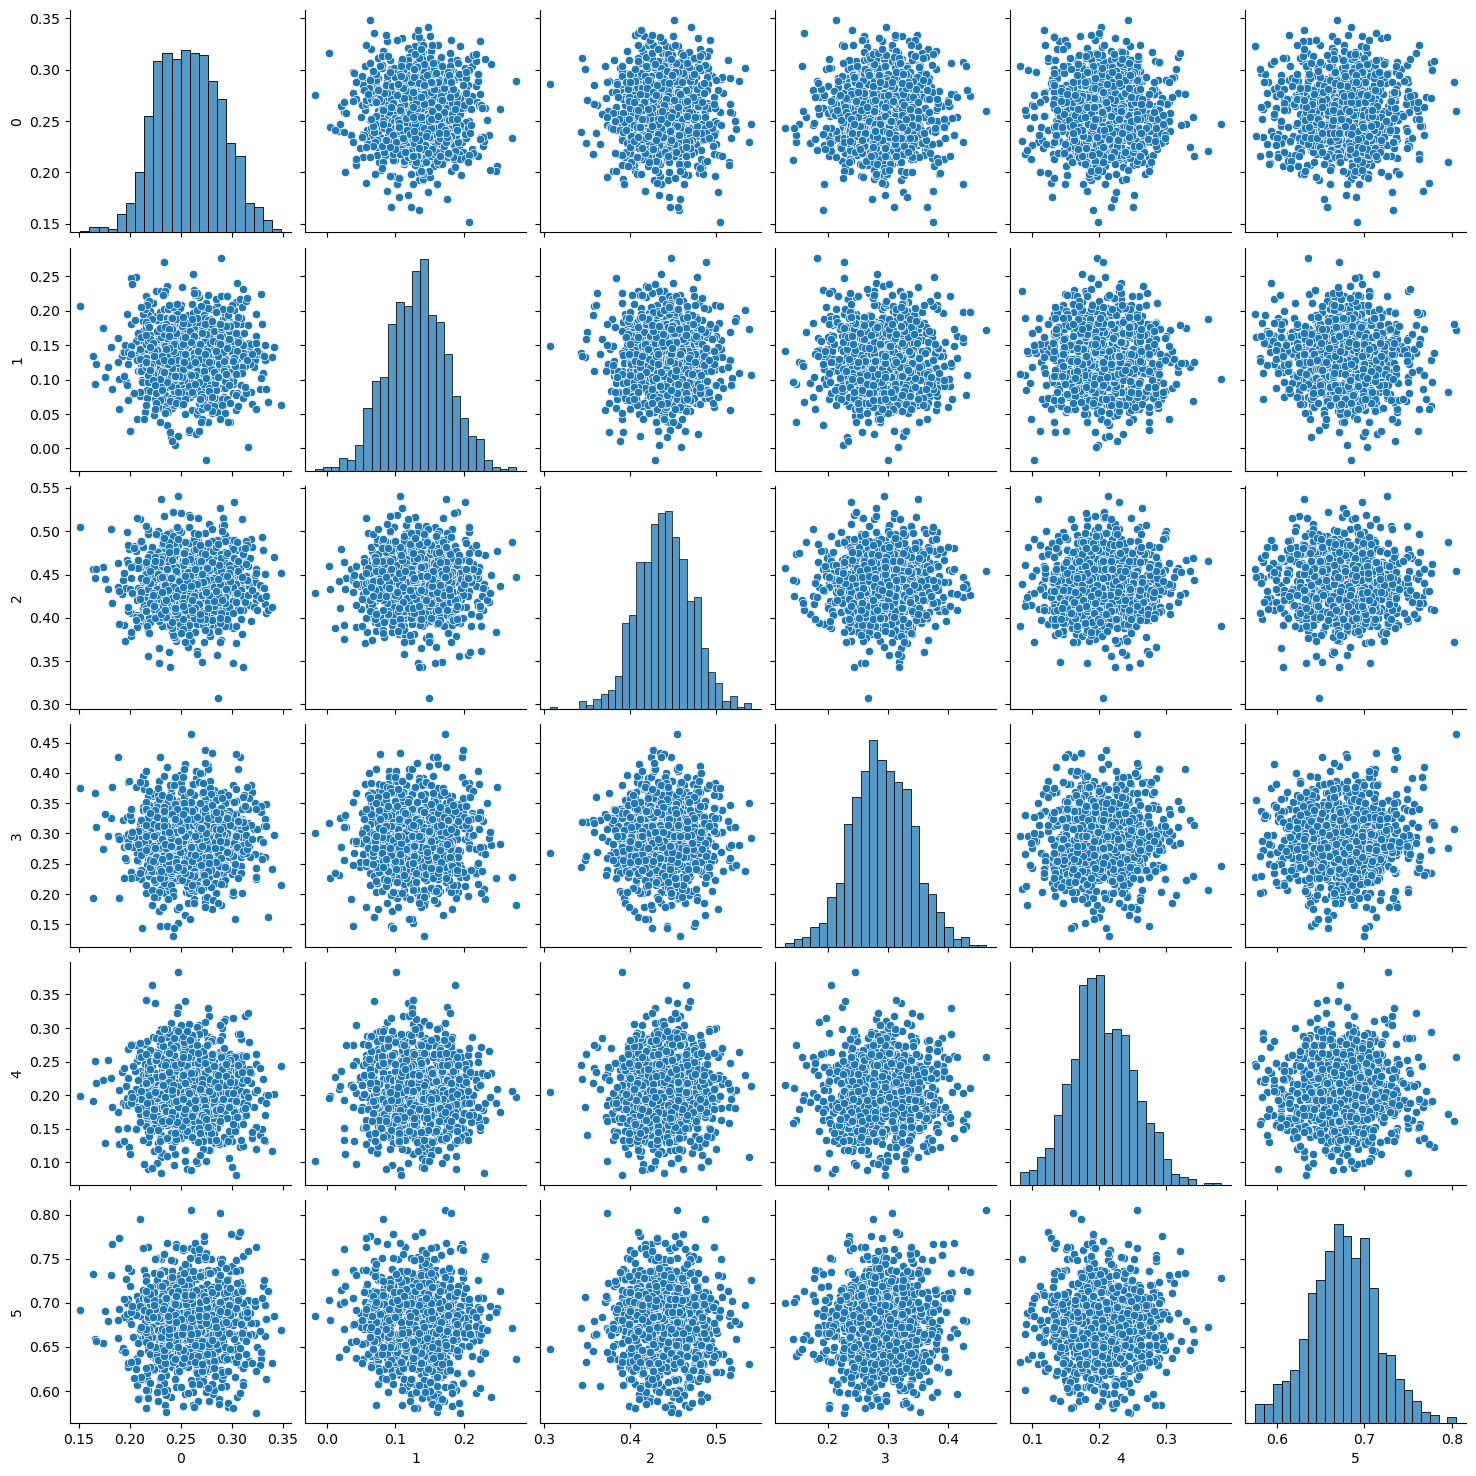

In [12]:
samples = prior.sample(1000)
sns.pairplot(pd.DataFrame(samples.numpy()))
plt.show()

We can see that the samples are more norrowed down toward true global optimum locations.

### 3.3 Run SOBER
That's all! Now we can run SOBER.

110) Best value: 3.19056e+00
Acquisition time [s]: 3.58043e+00, per sample [ms]: 3.58043e+02
120) Best value: 3.29104e+00
Acquisition time [s]: 7.31906e+00, per sample [ms]: 7.31906e+02
130) Best value: 3.31304e+00
Acquisition time [s]: 5.45253e+00, per sample [ms]: 5.45253e+02
140) Best value: 3.31991e+00
Acquisition time [s]: 3.40816e+00, per sample [ms]: 3.40816e+02
150) Best value: 3.32112e+00
Acquisition time [s]: 4.91678e+00, per sample [ms]: 4.91678e+02


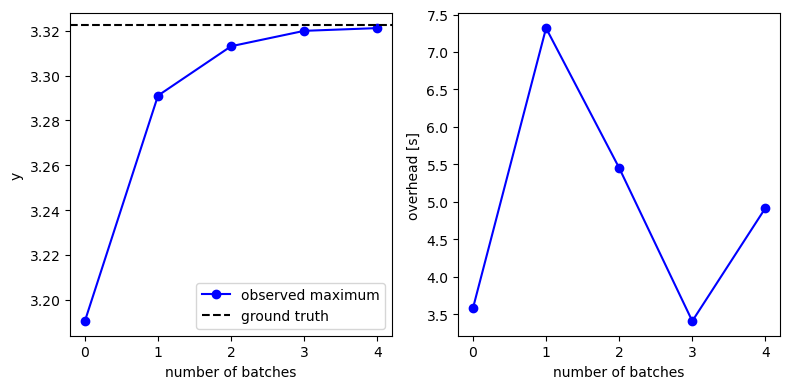

In [13]:
seed = 0           # random seed
batch_size = 10    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=3.32237)

As we can see, a better prior contributes much faster convergence.

<a id ="section4"></a>
## 4. Binary variables
We consider the combinatorial optimization task.<br>
As a toy example, we use MaxSat dataset. <br>
More details can be found in the SOBER paper<br>
- number of dimensions: 28
- variable type: binary
- ground truth: unknown (probably around 38.2)
- optimisation: maximisation

In [14]:
# load the MaxSat task
from experiments._maxsat import setup_maxsat
_, TestFunction = setup_maxsat()

### 4.1 Define the domain (prior)
A binary variable takes 0 or 1.<br>
So, the possible candidates in this task is $2^{28} \approx 2.7 \times 10^8$.
We assume a Bernoulli distribution as the prior.

In [15]:
n_dims = 28

from SOBER._prior import BinaryPrior # Import prior from SOBER libraries
prior = BinaryPrior(n_dims) 

### 4.2 Visualise prior

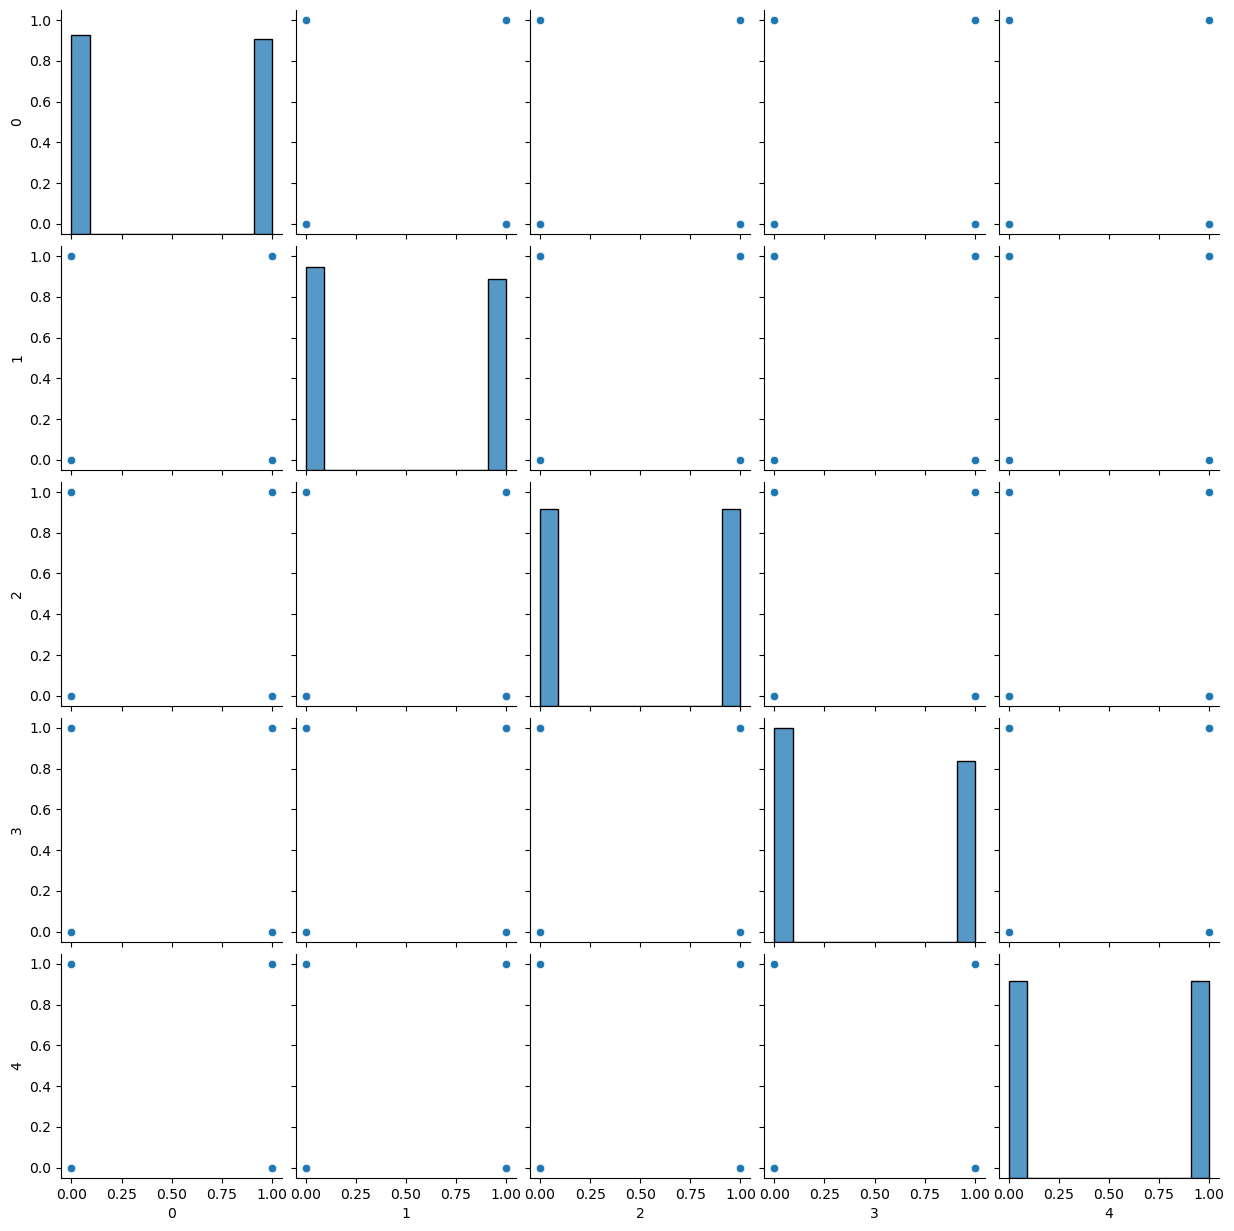

In [16]:
samples = prior.sample(1000)

# visualise the first 5 dimensions for speed
sns.pairplot(pd.DataFrame(samples[:,:5].numpy()))
plt.show()

We can confirm that the samples follow the bernoulli distribution with equal weights. 

### 4.3 Run SOBER
That's all! Now we can run SOBER.

300) Best value: 2.44955e+01
Acquisition time [s]: 1.27689e+00, per sample [ms]: 6.38447e+00
500) Best value: 3.17569e+01
Acquisition time [s]: 1.39241e+00, per sample [ms]: 6.96207e+00
Failed to update prior. Trying recursive sampling...
700) Best value: 3.17569e+01
Acquisition time [s]: 2.07767e+00, per sample [ms]: 1.03883e+01
The prior was initialised.
Failed to update prior. Trying recursive sampling...
900) Best value: 3.17569e+01
Acquisition time [s]: 2.76482e+00, per sample [ms]: 1.38241e+01
The prior was initialised.
Failed to update prior. Trying recursive sampling...
1100) Best value: 3.17569e+01
Acquisition time [s]: 4.57464e+00, per sample [ms]: 2.28732e+01


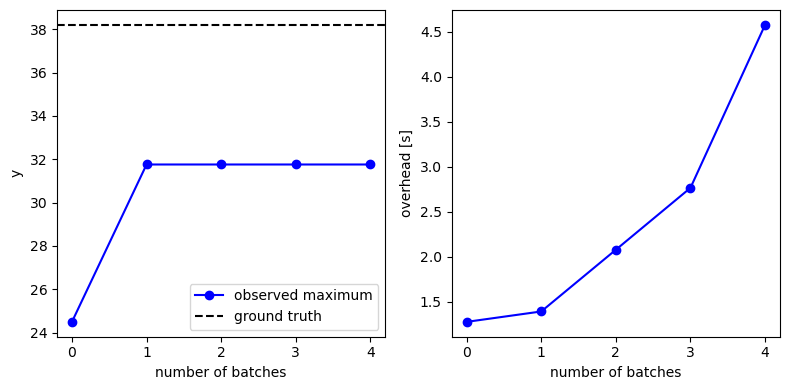

In [17]:
seed = 0           # random seed
batch_size = 200   # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=38.2)

SOBER can find nearly optimal combination by just observing 1000 samples ($10^5$ times smaller than search space).<br>
Moreover, this optimisation is with simple RBF kernel.<br>
That is, we can use more advanced GP modelling for faster convergence. <br>
We do not show it here but SOBER is model-agnostic, so that you can easily try out! 

<a id ="section5"></a>
## 5. Categorical variables
We consider the combinatorial optimization task.<br>
As a toy example, we use PestControl dataset. <br>
More details can be found in the SOBER paper<br>
- number of dimensions: 15
- variable type: categorical
- number of categories: 5 for each dimension
- ground truth: unknown (probably -7.07)
- optimisation: maximisation

In [18]:
# load the Pest task
from experiments._pest import setup_pest
_, TestFunction = setup_pest()

### 5.1 Define the domain (prior)
A categorical variable are selected from [0,1,2,3,4] (5 choices).<br>
So, the possible candidates in this task is $5^{15} \approx 3.1 \times 10^{10}$.
This is a more difficult task than MaxSat.
We assume a categorical distribution as the prior.

In [19]:
n_dims = 15
n_categories = 5

# set categories vector to be selected.
categories = torch.arange(n_categories).float().repeat(n_dims,1)
print(categories) # n_dims x n_categories

from SOBER._prior import CategoricalPrior # Import prior from SOBER libraries
prior = CategoricalPrior(categories)

tensor([[0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.],
        [0., 1., 2., 3., 4.]])


### 5.2 Visualise prior

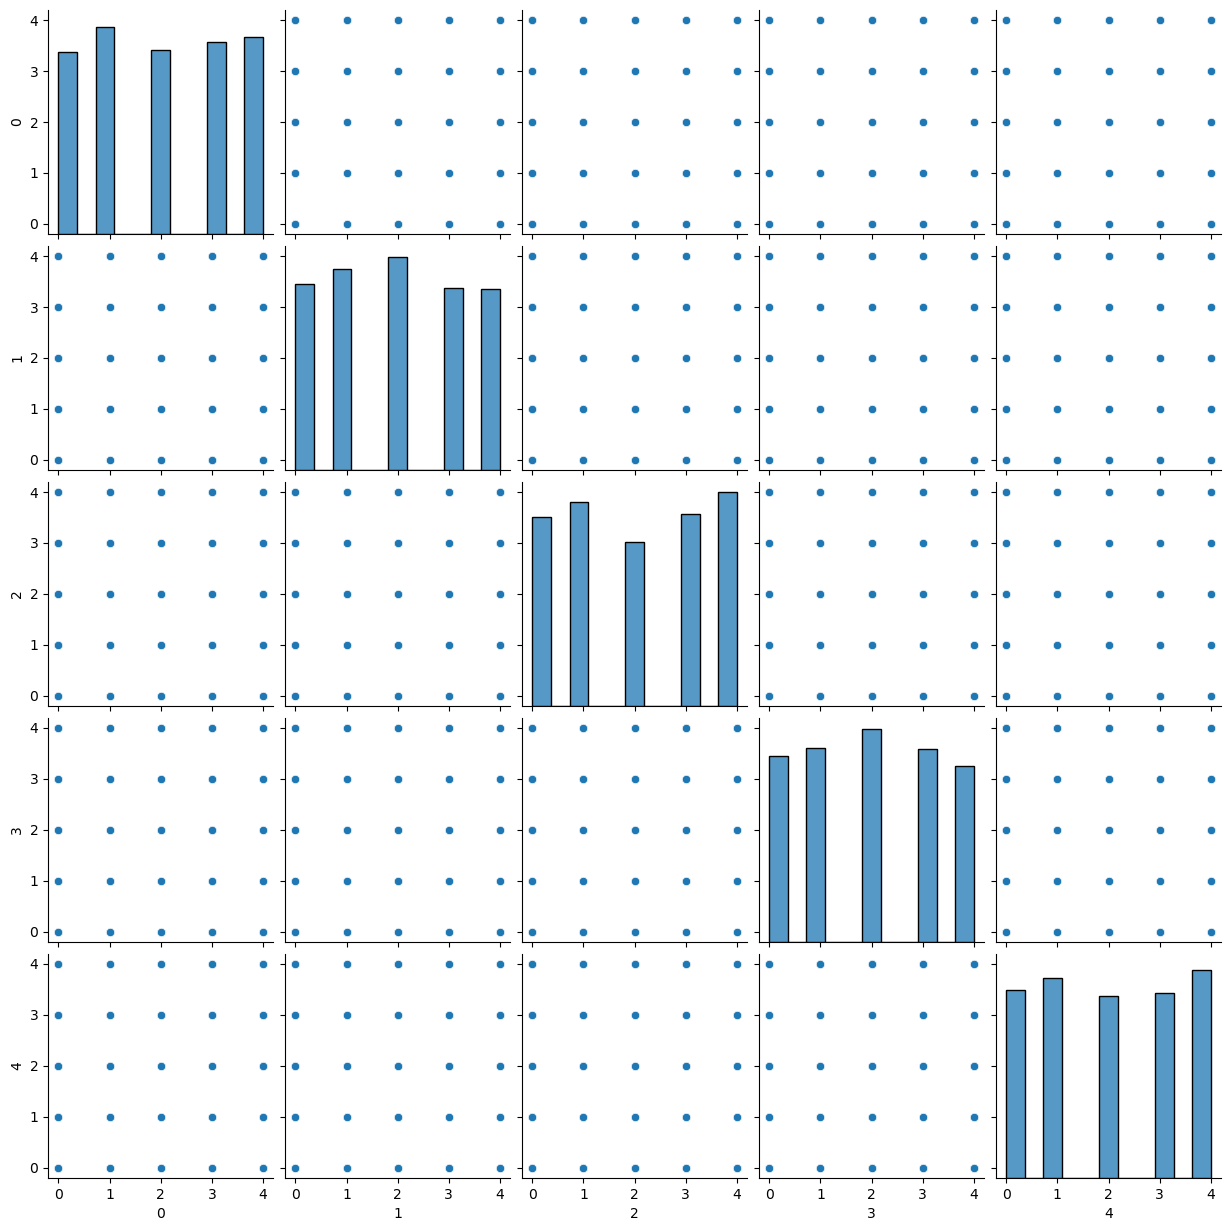

In [20]:
samples = prior.sample(1000)

# visualise the first 5 dimensions for speed
sns.pairplot(pd.DataFrame(samples[:,:5].numpy()))
plt.show()

We can confirm that the samples follow the categorical distribution with equal weights.

### 5.3 Run SOBER
That's all! Now we can run SOBER.

300) Best value: -9.13067e+00
Acquisition time [s]: 1.01985e+01, per sample [ms]: 5.09923e+01
500) Best value: -8.84467e+00
Acquisition time [s]: 2.81898e+01, per sample [ms]: 1.40949e+02
700) Best value: -7.77000e+00
Acquisition time [s]: 5.39125e+00, per sample [ms]: 2.69562e+01
900) Best value: -7.25600e+00
Acquisition time [s]: 9.23448e+00, per sample [ms]: 4.61724e+01
1100) Best value: -7.07000e+00
Acquisition time [s]: 1.17058e+01, per sample [ms]: 5.85290e+01


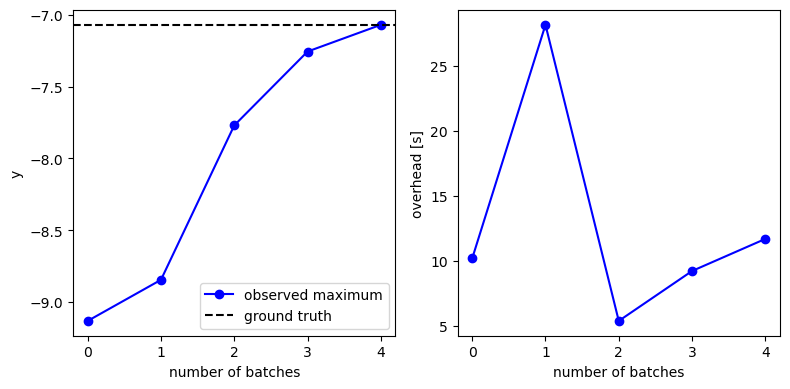

In [21]:
seed = 0           # random seed
batch_size = 200   # number of batch samples
n_rec = 100000     # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=-7.07)

<a id ="section6"></a>
## 6. Mixture of continuous and binary variables
We consider the mixture of continuous and binary variables.<br>
As a toy example, we use Ackley dataset. <br>
More details can be found in the SOBER paper<br>
- number of total dimensions: 23
- number of continuous dimensions: 3
- number of binary dimensions: 20
- variable type: mixture of continuous and binary
- bounds for continuous variables: from -1 to 1
- ground truth: 0
- optimisation: maximisation

In [22]:
# load the Ackley task
from experiments._ackley import setup_ackley
_, TestFunction = setup_ackley()

### 6.1 Define the domain (prior)
The first 3 dimensions are continuous bounded from -1 to 1, and the rest of 20 dimensions is binary variables.
We assume the prior which is the product of uniform distribution and Bernoulli distribution (assuming independence between continuous and binary variables).

In [23]:
# Setting continuous prior
n_dims_cont = 3
lower_limit = -1
upper_limit = 1
mins = lower_limit * torch.ones(n_dims_cont)
maxs = upper_limit * torch.ones(n_dims_cont)
bounds = torch.vstack([mins, maxs]) # bounds

# Setting binary prior
n_dims_binary = 20  # number of dimensions for binary variables

from SOBER._prior import MixedBinaryPrior # Import prior from SOBER libraries
prior = MixedBinaryPrior(
    n_dims_cont, 
    n_dims_binary, 
    bounds,
    continous_first=True, # [cont, binary] if true, otherwise [binary, cont]
)

### 6.2 Visualise prior

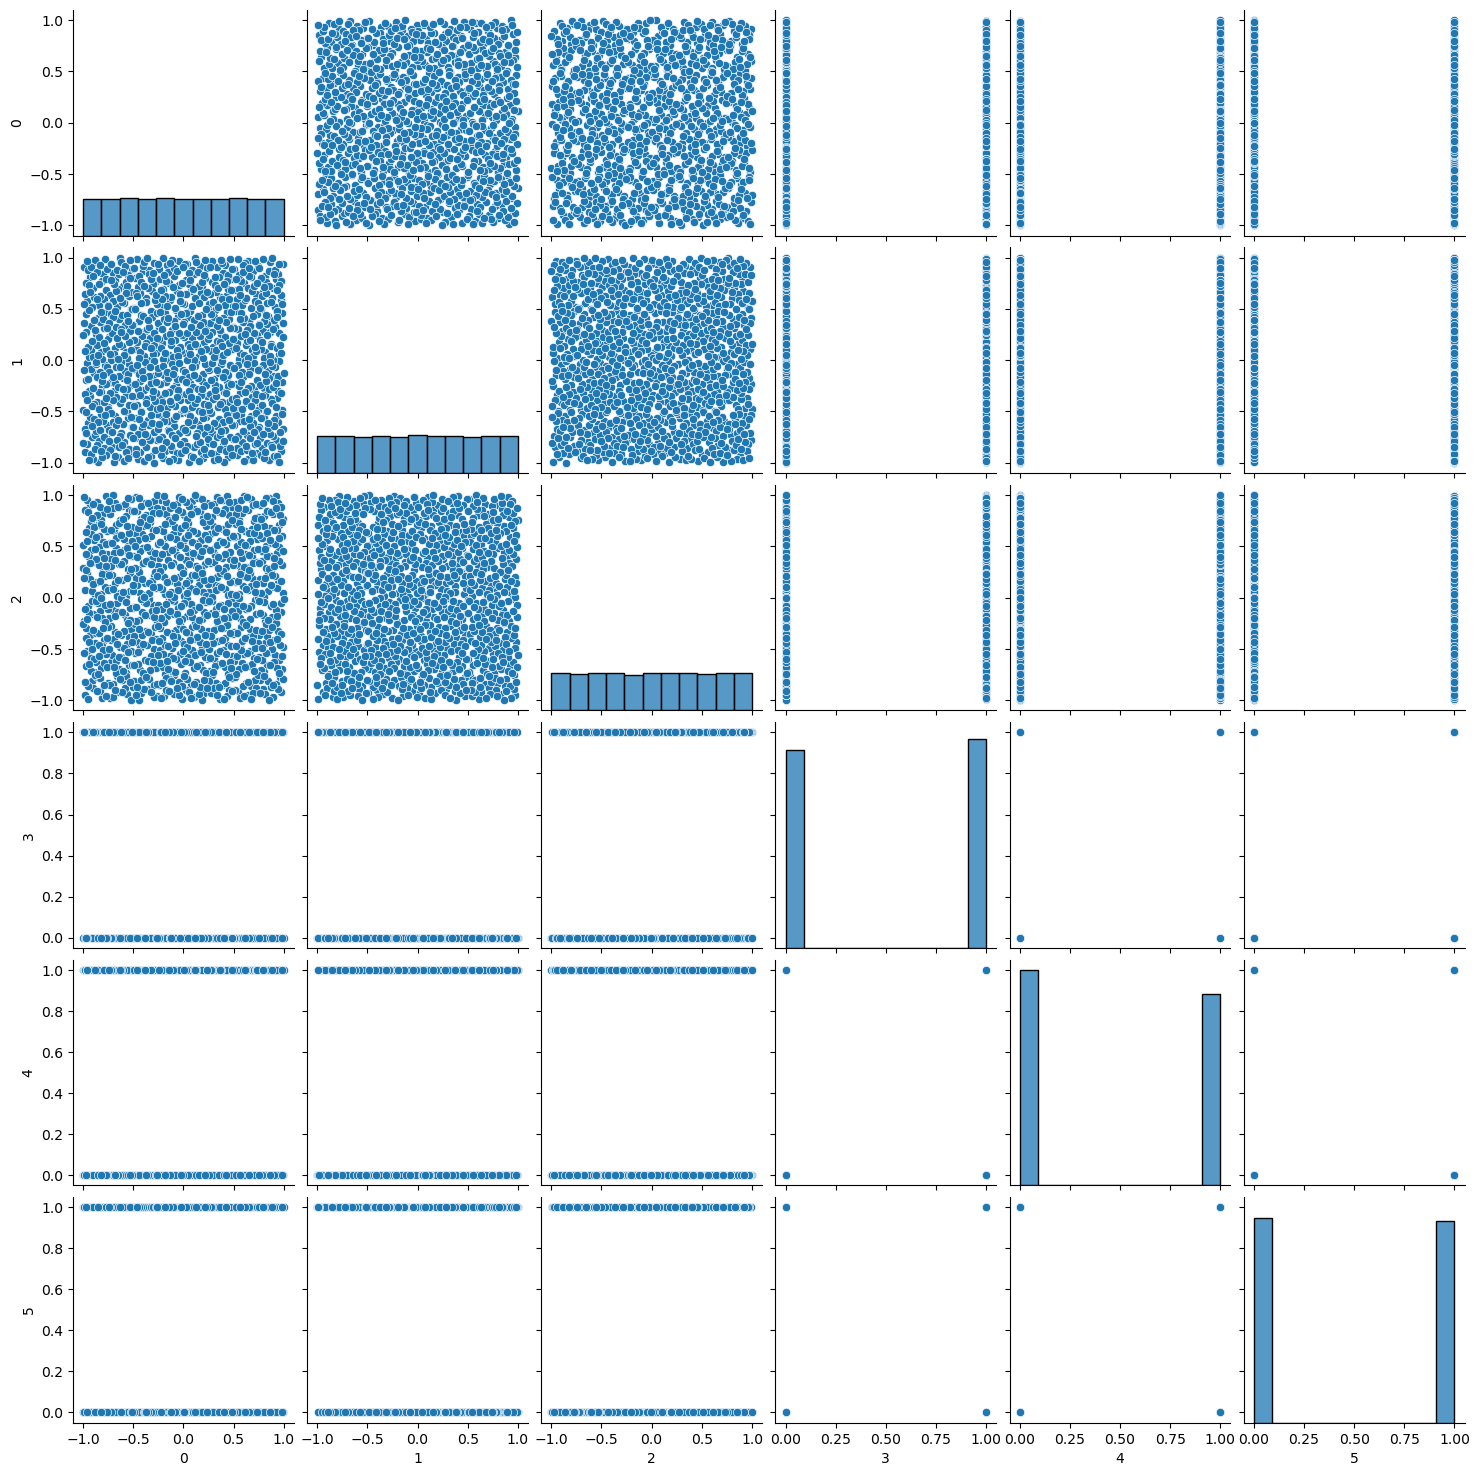

In [24]:
samples = prior.sample(1000)

# visualise the first 6 dimensions for speed
sns.pairplot(pd.DataFrame(samples[:,:6].numpy()))
plt.show()

We can confirm that the samples follow the mixture distribution.<br>
The first 3 dimensions follow a uniform distribution bounded between -1 and 1.<br>
The rest of dimensions follow a binary distribution with equal weights.

### 6.3 Run SOBER
That's all! Now we can run SOBER.

300) Best value: -1.01523e+00
Acquisition time [s]: 3.55900e+00, per sample [ms]: 1.77950e+01
500) Best value: -1.40693e-01
Acquisition time [s]: 8.09497e+00, per sample [ms]: 4.04749e+01
700) Best value: -1.31006e-02
Acquisition time [s]: 7.36488e+00, per sample [ms]: 3.68244e+01
900) Best value: -7.15351e-03
Acquisition time [s]: 6.43902e+00, per sample [ms]: 3.21951e+01
1100) Best value: -7.15351e-03
Acquisition time [s]: 8.52743e+00, per sample [ms]: 4.26371e+01


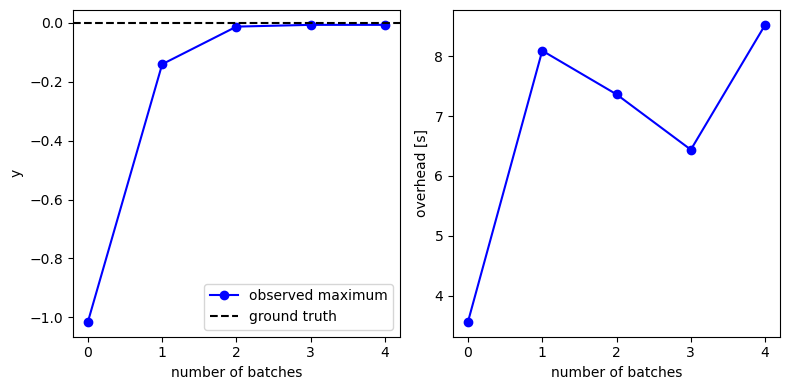

In [25]:
seed = 0           # random seed
batch_size = 200   # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=0)

<a id ="section7"></a>
## 7. Mixture of continuous and categorical variables
We consider the mixture of continuous and categorical variables.<br>
As a toy example, we use Rosenbrock dataset. <br>
More details can be found in the SOBER paper<br>
- number of total dimensions: 7
- number of continuous dimensions: 1
- number of binary dimensions: 6
- number of categories: 4
- variable type: mixture of continuous and categorical variables
- bounds for continuous variables: from -4 to 11
- ground truth: 0
- optimisation: maximisation

In [26]:
# load the Rosenbrock task
from experiments._rosenbrock import setup_rosenbrock
_, TestFunction = setup_rosenbrock()

### 7.1 Define the domain (prior)
The first 1 dimension is continuous bounded from -4 to 11, and the rest of 6 dimensions is categorical variables.
We assume the prior which is the product of uniform distribution and categorical distribution (assuming independence between continuous and categorical variables).

In [27]:
# Setting continuous prior
n_dims_cont = 1
lower_limit = -4
upper_limit = 11
mins = lower_limit * torch.ones(n_dims_cont)
maxs = upper_limit * torch.ones(n_dims_cont)
bounds = torch.vstack([mins, maxs]) # bounds

# Setting binary prior
n_dims_disc = 6  # number of dimensions for categorical variables
categories = torch.tensor([
    [-4,  1,  6, 11],
]).float().repeat(n_dims_disc,1)
print(categories)

from SOBER._prior import MixedCategoricalPrior # Import prior from SOBER libraries
prior = MixedCategoricalPrior(
    n_dims_cont, 
    n_dims_disc,
    categories,
    bounds,
    continous_first=True, # [cont, binary] if true, otherwise [binary, cont]
)

tensor([[-4.,  1.,  6., 11.],
        [-4.,  1.,  6., 11.],
        [-4.,  1.,  6., 11.],
        [-4.,  1.,  6., 11.],
        [-4.,  1.,  6., 11.],
        [-4.,  1.,  6., 11.]])


### 7.2 Visualise prior

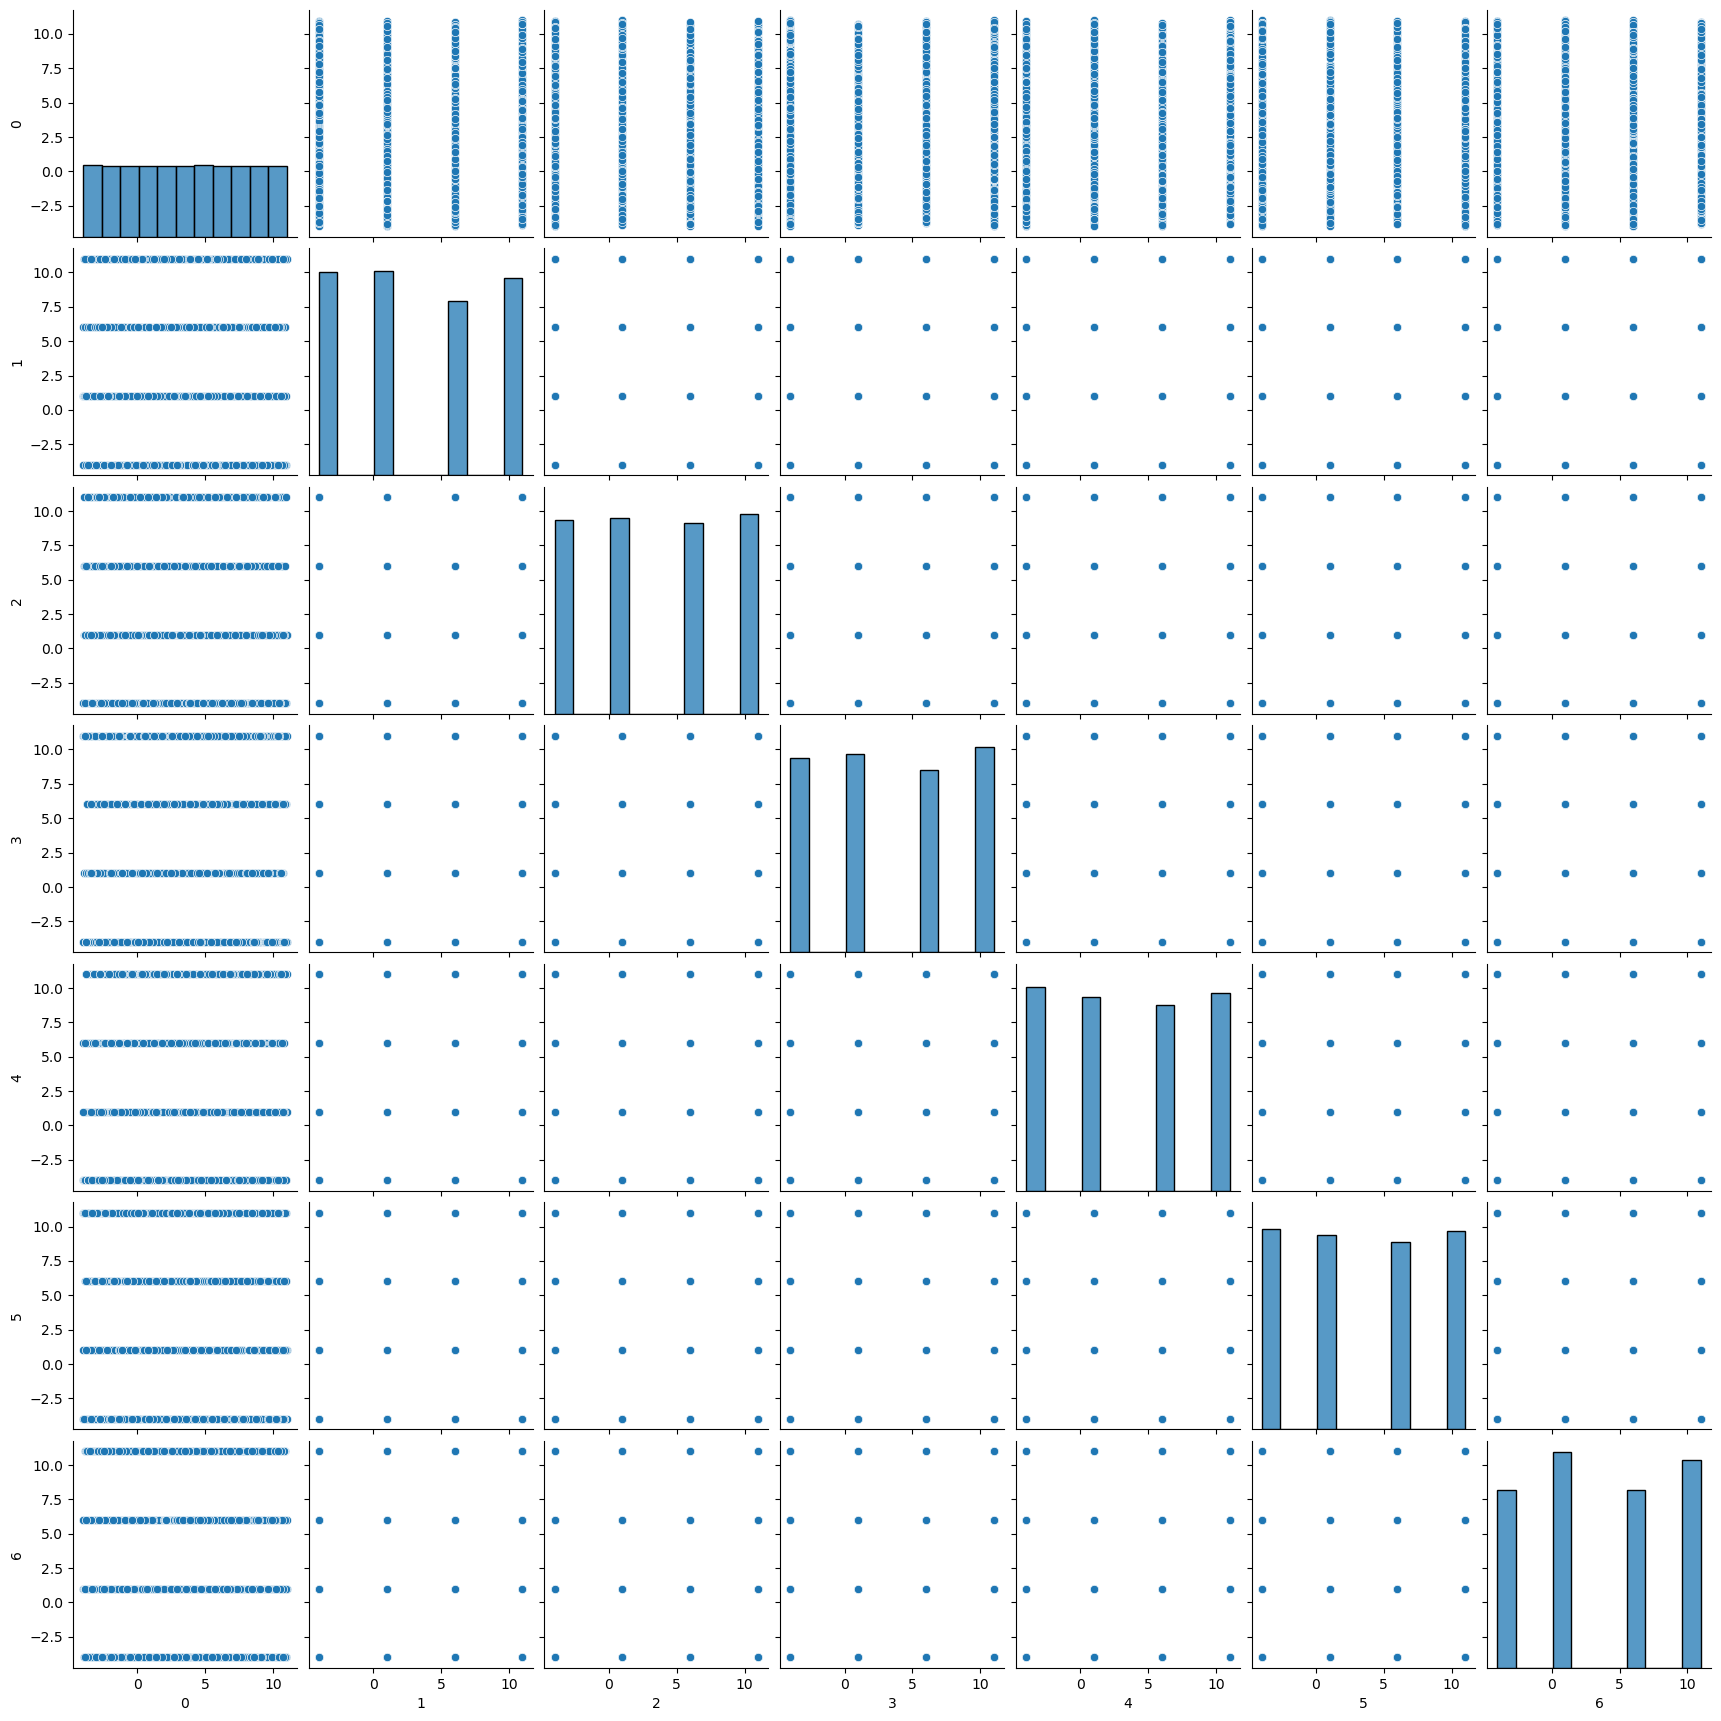

In [28]:
samples = prior.sample(1000)

# visualise the first 6 dimensions for speed
sns.pairplot(pd.DataFrame(samples.numpy()))
plt.show()

We can confirm that the samples follow the mixture distribution.<br>
The first 1 dimension follows a uniform distribution bounded between -4 and 11.<br>
The rest of dimensions follow a categorical distribution with equal weights.

### 7.3 Run SOBER
That's all! Now we can run SOBER.

200) Best value: -1.74991e+03
Acquisition time [s]: 2.50144e+00, per sample [ms]: 2.50144e+01
300) Best value: -6.07283e+00
Acquisition time [s]: 3.58856e+00, per sample [ms]: 3.58856e+01
400) Best value: -1.45550e-02
Acquisition time [s]: 3.58310e+00, per sample [ms]: 3.58310e+01
500) Best value: -1.43469e-03
Acquisition time [s]: 4.79083e+00, per sample [ms]: 4.79083e+01
600) Best value: -1.50824e-05
Acquisition time [s]: 2.76268e+00, per sample [ms]: 2.76268e+01


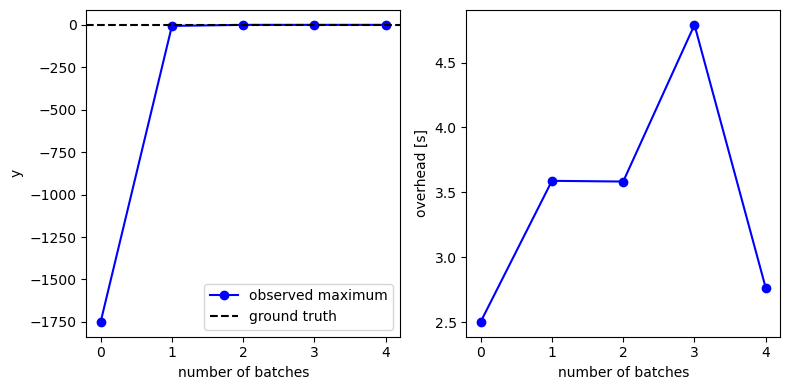

In [29]:
seed = 30          # random seed
batch_size = 100   # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 5   # number of iterations (batches)
obj = None         # acquisition function

results = run_SOBER(
    seed,
    batch_size,        # number of batch samples
    n_rec,             # number of candidates sampled from pi
    n_nys,             # number of samples for Nyström approximation
    n_init,            # number of initial samples
    n_iterations,      # number of iterations (batches)
    obj=obj,           # acquisition function
)

visualise_results(results, y_true=0)

<a id ="section8"></a>
## 8. Domain as a dataset
Lastly, we consider the search space is given as a dataset.<br>
As a toy example, we use anti-malarial drug discovery dataset. <br>
More details can be found in the SOBER paper<br>
- number of binary dimensions: 2,048
- number of data: 18,924
- domain type: dataset
- ground truth: -5.72e-04
- optimisation: maximisation

Here, we model GP with Tanimoto kernel.

In [30]:
from SOBER._drug_modelling import TanimotoGP

def set_tanimoto_gp_model(X, Y):
    """
    Set up the Gaussian process model with Tanimoto kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    model = TanimotoGP(X, train_Y)
    return model

def fit_model(X, Y):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    model = set_tanimoto_gp_model(X, Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [31]:
# load the Malaria task
from experiments._malaria import featurise_dataset
MALARIA_DIR_NAME = "../experiments/dataset/"
data_filename = "malaria_box_dataset.csv"
data_path = os.path.join(MALARIA_DIR_NAME, data_filename)
features, true_targets = featurise_dataset(data_path)
print(features)
print(true_targets)
print(features.shape, true_targets.shape)

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([-1.3720, -0.8550, -0.5656,  ..., -0.6540, -0.6530, -0.6530])
torch.Size([18924, 2048]) torch.Size([18924])


The features are the 2,048 binary features of molecules.<br>
The true_targets are the corresponding value to maximise (drug efficacy)<br>

### 8.1 Define the domain (prior)
If we think this task as binary domain, the possible candidates are $2^{2048} \approx 3.2 \times 10^{617}$.<br>
This is too large to search, so we pay attention to the dataset size.<br>
Actually, this dataset only contains 18,924 drugs.<br>
Finding the best drug from 18,924 **discrete** variables is much easier to find.<br>
We assume the domain as 1 dimensional categorical variable with 18,924 categories.<br>
We prepare the special prior for this case called **dataset prior**.<br>
All we need to do is to pass the features and true values.<br>

In [32]:
from SOBER._prior import DatasetPrior
prior = DatasetPrior(features, true_targets)

### 8.2 Run SOBER
That's all! Now we can run SOBER.<br>
The way to run SOBER on dataset prior is slightly different from the above examples.<br>
But it is not too different.<br>
The difference is that prior holds the true values, so the prior also plays a role of the test function. <br>

In [33]:
seed = 0           # random seed
batch_size = 200   # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_init = 100       # number of initial samples
n_iterations = 10  # number of iterations (batches)
obj = None         # acquisition function

300) Best value: -3.20000e-03
Acquisition time [s]: 4.46656e+00, per sample [ms]: 2.23328e+01
500) Best value: -3.20000e-03
Acquisition time [s]: 4.25269e+00, per sample [ms]: 2.12634e+01
700) Best value: -3.20000e-03
Acquisition time [s]: 3.94811e+00, per sample [ms]: 1.97406e+01
900) Best value: -3.20000e-03
Acquisition time [s]: 6.24131e+00, per sample [ms]: 3.12066e+01
1100) Best value: -2.44400e-03
Acquisition time [s]: 7.63456e+00, per sample [ms]: 3.81728e+01
1300) Best value: -2.44400e-03
Acquisition time [s]: 8.88242e+00, per sample [ms]: 4.44121e+01
1500) Best value: -9.86000e-04
Acquisition time [s]: 1.64566e+01, per sample [ms]: 8.22828e+01
1700) Best value: -9.86000e-04
Acquisition time [s]: 1.59822e+01, per sample [ms]: 7.99112e+01
1900) Best value: -9.86000e-04
Acquisition time [s]: 1.89030e+01, per sample [ms]: 9.45152e+01
2100) Best value: -9.86000e-04
Acquisition time [s]: 2.02882e+01, per sample [ms]: 1.01441e+02


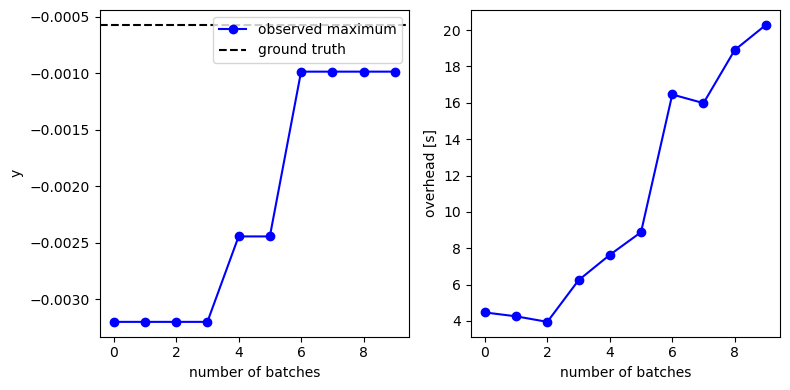

In [34]:
torch.manual_seed(seed)  # random seed

# initial sampling
Xall, Yall = prior.sample(n_init)  # Sampling not only features, but also true values.
model = set_tanimoto_gp_model(Xall, Yall)
sober = Sober(prior, model, kernel_type="weighted_predictive_covariance")

results = []
for n_iter in range(n_iterations):
    start = time.monotonic()
    model = fit_model(Xall, Yall)
    sober.update_model(model)           # pass the updated model to sober
    idx_batch, X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=obj,
        verbose=False,
    )
    end = time.monotonic()
    interval = end - start

    Y_batch = prior.query(idx_batch)      # query true values to the prior
    Xall = torch.cat((Xall, X_batch), dim=0)
    Yall = torch.cat((Yall, Y_batch), dim=0)

    print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Yall.max().item()])

results = torch.tensor(results)
visualise_results(results, y_true=-5.72e-04)